In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_E6oV3lV.csv')
print("Training Set:"% train.columns, train.shape)
test = pd.read_csv('test_tweets_anuFYb8.csv')
print("Test Set:"% test.columns, test.shape)

print('Train_Set -----')
print(train.isnull().sum())
print('Test_set -----')
print(test.isnull().sum())
train.head()

Training Set: (31962, 3)
Test Set: (17197, 2)
Train_Set -----
id       0
label    0
tweet    0
dtype: int64
Test_set -----
id       0
tweet    0
dtype: int64


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
train.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [4]:
import re
from sklearn.utils import resample

def  clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    return df
test_clean = clean_text(test, "tweet")
train_clean = clean_text(train, "tweet")

train_majority = train_clean[train_clean.label==0]
train_minority = train_clean[train_clean.label==1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,    
                                 n_samples=len(train_majority),   
                                 random_state=123)
train_upsampled = pd.concat([train_minority_upsampled, train_majority])
train_upsampled['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

In [7]:
!pip install xgboost
import xgboost as xgb
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score

pipeline_xgb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf',  TfidfTransformer()),
    ('nb', xgb.XGBClassifier(use_label =False)),])

x_train, x_test, y_train, y_test = train_test_split(train_upsampled['tweet'],
                                                    train_upsampled['label'],random_state = 0)
model = pipeline_xgb.fit(x_train, y_train)
y_predict = model.predict(x_test)
print('--'* 20)
print('F1_Score: ',f1_score(y_test, y_predict))
print('Accuracy_Score: ', accuracy_score(y_test, y_predict))
print('--'*20)
print('---RepeatedKFOLD---')
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state =1)
score2 = cross_val_score(pipeline_xgb, x_train, y_train, cv=cv, scoring='f1_micro', n_jobs=1)
score2 = np.mean(score2)
print('--'* 20)
print('RKFold_Score: ', score2)
print('--'* 20)

     -------------------------------------- 89.1/89.1 MB 328.0 kB/s eta 0:00:00
[20:35:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "use_label" } are not used.

----------------------------------------
F1_Score:  0.9159862338889263
Accuracy_Score:  0.9162180349932705
----------------------------------------
---RepeatedKFOLD---
[20:35:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "use_label" } are not used.

[20:35:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "use_label" } are not used.

[20:35:44] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
print('--- Axis1 = ref_val, Axis0 = pred_val ---')

x_val, y_val = x_test, y_test

yhat = model.predict_proba(x_val)
ypred = model.predict(x_val)
print('Confusion_Matrix: ')
print(confusion_matrix(y_val, ypred, labels = [1,0]).T)
print('Precsion_Score: ', precision_score(y_val, ypred, labels = [1,0]))
print('Recall_Score: ', recall_score(y_val, ypred, labels = [1,0]))

print('y_hat_shape: ',yhat.shape)
yhat = yhat[:,1]

--- Axis1 = ref_val, Axis0 = pred_val ---
Confusion_Matrix: 
[[6787  662]
 [ 583 6828]]
Precsion_Score:  0.9111290106054504
Recall_Score:  0.9208955223880597
y_hat_shape:  (14860, 2)



random_classifier: ROC AUC=0.500
XGBclassifier: ROC AUC=0.976


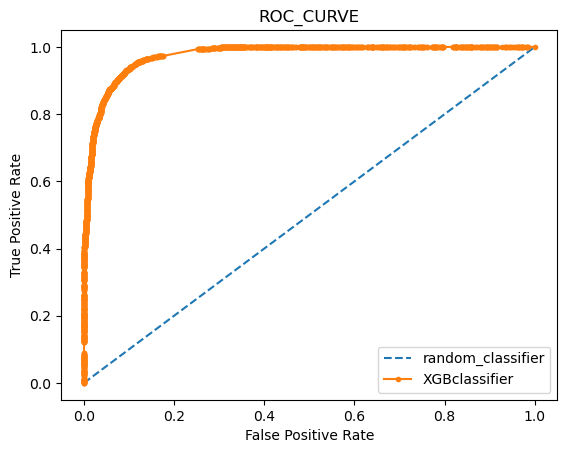

In [9]:
ns_probs = [0 for _ in range(len(y_val))]
ns_auc = roc_auc_score(y_val, ns_probs, labels = [1,0])
lr_auc = roc_auc_score(y_val, yhat, labels = [1,0])
print()
print('random_classifier: ROC AUC=%.3f' % (ns_auc))
print('XGBclassifier: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, yhat)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='random_classifier')
plt.plot(lr_fpr, lr_tpr, marker='.', label='XGBclassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC_CURVE')
plt.show()

auc-score:  0.9733875328219912
f1-score:  0.9159862338889263


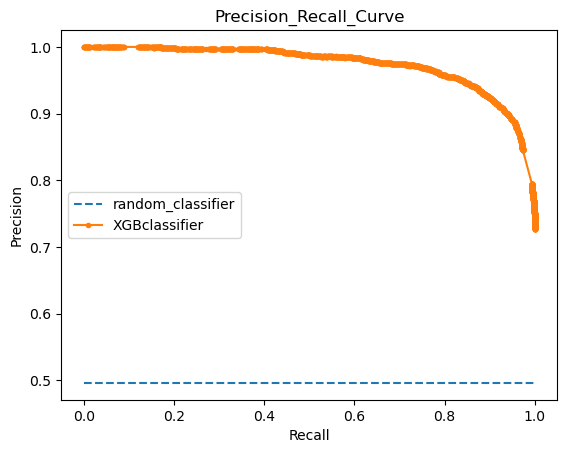

In [10]:
lr_precision, lr_recall, _ = precision_recall_curve(y_val, yhat)
print('auc-score: ',auc(lr_recall, lr_precision))
print('f1-score: ', f1_score(y_val, ypred, labels = [1,0]))
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='random_classifier')
plt.plot(lr_recall, lr_precision, marker='.', label='XGBclassifier')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision_Recall_Curve')
plt.show()

In [28]:
def predict(inp):
    inp = pd.Series(inp)
    yhat = ((np.ravel(model.predict(inp)).tolist()))
    if yhat[-1] == 1:
        print('Conc : Hate_Comment_Detected_😔')
    if yhat[-1] == 0:
        print('Conc: Not_a_hate_comment_😄')
    

inp = [' I hate humans and dogs !! they suck ', 'I love playing soccer ']
for i in inp:
    print('Entered_Comment: ', i)
    predict(i)
    print('--'*30)

Entered_Comment:   I hate humans and dogs !! they suck 
Conc : Hate_Comment_Detected_😔
------------------------------------------------------------
Entered_Comment:  I love playing soccer 
Conc: Not_a_hate_comment_😄
------------------------------------------------------------


In [16]:
def predict(inp):
    
    inp = pd.Series(inp)
    yhat = ((np.ravel(model.predict(inp)).tolist()))
    if yhat[-1] == 1:
        print('Conc : Hate_Comment_Detected_😔')
        c=1
    if yhat[-1] == 0:
        print('Conc: Not_a_hate_comment_😄')
        c=1
    return yhat[-1]
        
inp = [' I hate humans and dogs !! they suck ', 'I love playing soccer ','i love roses','i hate blacks']
n=0
p=0
for i in inp:
    print('Entered_Comment: ', i)
    c = predict(i)
    if c == 1:
        n+=1
    if c == 0:
        p+=1

print('--'*30)
print(n,'Hate comments and ',p, 'positive comments')
print('--'*30)
    

Entered_Comment:   I hate humans and dogs !! they suck 
Conc : Hate_Comment_Detected_😔
Entered_Comment:  I love playing soccer 
Conc: Not_a_hate_comment_😄
Entered_Comment:  i love roses
Conc: Not_a_hate_comment_😄
Entered_Comment:  i hate blacks
Conc : Hate_Comment_Detected_😔
------------------------------------------------------------
2 Hate comments and  2 positive comments
------------------------------------------------------------
